# Deep Learning - Programing Assignment 4
# Recurrent Neural Networks
By Shu-Nong Wu | RIN: 661371234 | RCS: wus7
## 1. Introduction
&emsp;
Previous programming assignments focused on static neural networks with time invariant inputs and outputs. These architectures are incapable of effectively train on sequential data. A deep neural network (DNN) and convolutional neural network can not handle information that propagate through time as there is no mechanism for saving the states. This is problematic as there are some situations where the current input is dependant on the previous input. Take for example a sequence of words (sentence), sequence of images (video), or stock prices. The meaning of a word depends on its previous word, the location of a car in a frame of a video is related to its location on the previous frame, and tomorrows stock price depends on events that happen today. Problems like these are perfect for another class of neural networks known as **recurrent neural networks**.
&emsp;

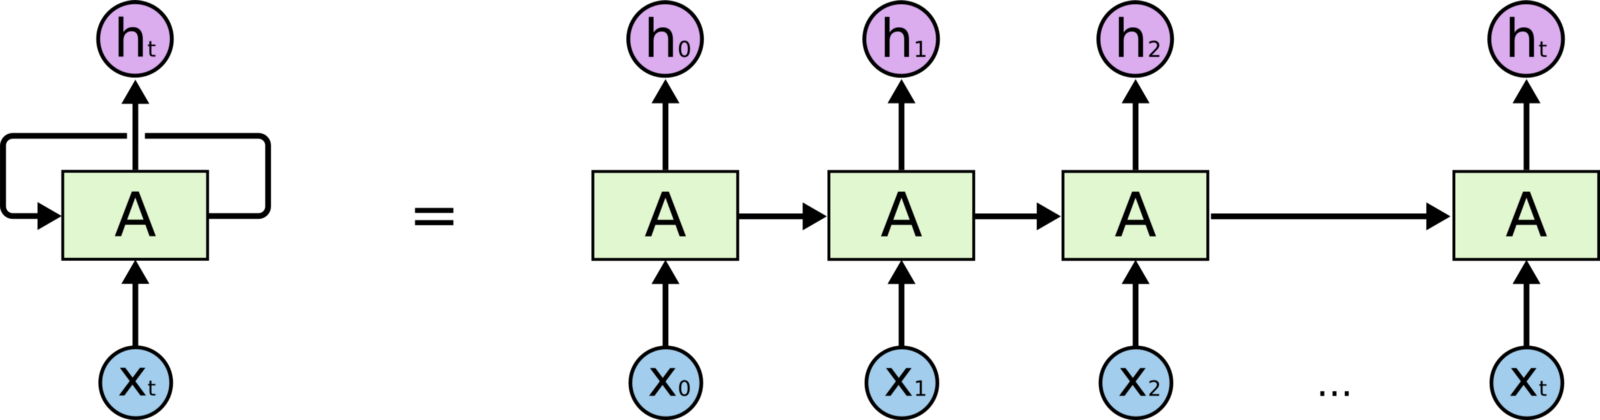

In [64]:
from IPython.display import Image
Image(filename='report/rnn_diagram.png')

Source: https://towardsdatascience.com/introduction-to-recurrent-neural-network-27202c3945f3

&emsp;
The recurrent neural network or RNN is simular to a deep neural network or DNN except with one small modification. The output of the recurrent neuron or node of a RNN is not only propagated forward into the next layer of the network, but is it also multiplied by a set of weights and fed back into the input of the next squence or time period. What this does is allows the result of one state to effect the result of the next state. This effectivly gives the RNN memory enabling it to leverage past data to predict future data.

&emsp;
However the RNN is not without flaws. For incredibly long and complex sequences of data the RNN is not about to capture such patterns and make good predictions. Take for example a student taking a complicated test in which he is allowed a cribsheet. It would not be practical to write down everything from the lecture slide onto the crib sheet as the student taking test. Rather it is important to distiguish between useful information that should be remembered and random and isolated pieces of information that ought to be forgotten. The **long short term memory** or LSTM is a flavor of RNNs which are able to forget some information or states while remembering others. In conclusion, LSTMs can learn patterns in data that span through much longer sequences.

&emsp;
This programing assignment uses RNNs to do pose estimation. Pose estimation is when given a video of a person, track the location of his or her joints. These joints consist of head, right shoulder, left shoulder, right wrist, left wrist, right
elbow, and left elbow. The dataset used in this assignment is the Youtube pose dataset which is dataset of various people talking and moving their joints. In order to properly localize the joint locations, a CNN must be stacked on top of a RNN. The CNN takes in the images and extracts features that will be put into the RNN.

#### Import Dependencies

In [66]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import logging
from pa4_utils import *
from tqdm import tnrange, tqdm_notebook
from datetime import datetime

#### Load and Preprocess Data
The images need to be normalized to make the network more robust to changes in shading/illumination

In [5]:
# def normalize_data(sequences):
#     sequences = sequences.astype(np.float32)
#     sequences -= np.mean(sequences, axis=(2, 3, 4), keepdims=True)
#     sequences /= np.std(sequences, axis=(2, 3, 4), keepdims=True)
#     return sequences

# with open('youtube_train_data.pkl', 'rb') as data_file:
#     sequences, labels = pickle.load(data_file)
# train_seq, train_labels, test_seq, test_labels = split_data(sequences, labels)
# train_seq = normalize_data(train_seq)
# test_seq = normalize_data(test_seq)
# with open('youtube_data_processed.pkl', 'wb') as write_file:
#     pickle.dump((train_seq,train_labels,test_seq,test_labels), write_file)

with open('youtube_data_processed.pkl', 'rb') as data_file:
    train_seq, train_labels, test_seq, test_labels = pickle.load(data_file)
train_data = Data(train_seq, train_labels)
test_data = Data(test_seq, test_labels)

## 2. Theory
&emsp;
To implement a neural network one needs to define hyper parameters, initialize weights and biases, define the neural network architecture, define optimizer, and perform training.
### 2.1. Hyper Parameters
Dropout and batch normalization was applied adding 2 new hyperparameters dropout rate for **dropout** and momentum for **batch normalization**. The theory behind these two neural network augmentations will not be discussed in this report.

In [17]:
LEARNING_RATE = .001
LAMBDA = .001
NUM_STEPS = 5000
BATCH_SIZE = 16
DROPOUT_RATE = .5
BN_MOMENTUM = .975

### 2.2. Model Parameters
&emsp;
The model parameters define the architecture of the model such as number of layers and it's type as well as specifics of each layer such as number of filters, fully connected nodes, and recurrent nodes.

In [33]:
l2_reg = tf.contrib.layers.l2_regularizer(LAMBDA)

# CNN   
CONV_L1_PARAM = dict(filters=8,
                     kernel_size=(1,6,6),
                     padding='VALID',
                     activation=tf.nn.relu,
                     regularization=None)
CONV_L2_PARAM = dict(filters=16,
                     kernel_size=(1,6,6),
                     padding='VALID',
                     activation=tf.nn.relu,
                     regularization=None)

CONV_L3_PARAM = dict(filters=32,
                     kernel_size=(1,3,3),
                     padding='VALID',
                     activation=tf.nn.relu,
                     regularization=None)

FC_L1_PARAM = dict(units=256,
                   activation=tf.nn.relu,
                   drop_rate=DROPOUT_RATE,
                   bn_momentum=BN_MOMENTUM,
                   regularization=None)

#RNN
NUM_RNN_UNITS = 64
NUM_RNN_LAYERS = 3
LSTM_ACT_FUN = tf.nn.relu

### 2.3. Define Model
&emsp;
Because the input to this network is a sequence of images there first needs to be a convolutional neural network or CNN that detects features to be passed on to the RNN. The full architecture is shown below.

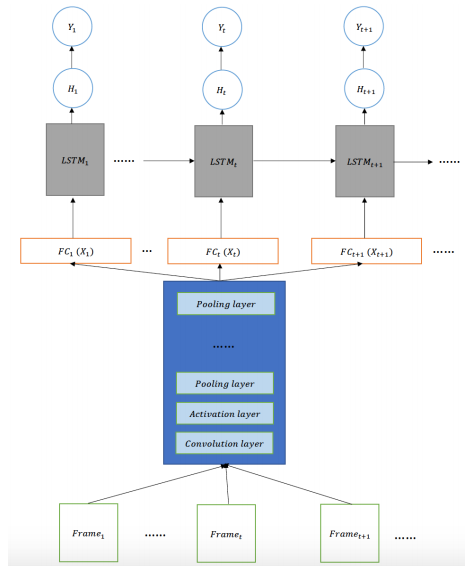

In [34]:
Image(filename='report\cnn_rnn.PNG')

Source: Programing assignment instructions

#### 2.3.1. Convolutional Neural Network
&emsp;
The theory behind CNNs will not be discussed in this report.

In [35]:
tf.reset_default_graph()

xavier_init = tf.contrib.layers.xavier_initializer()
zero_init = tf.zeros_initializer()

def convolutional_layer(inputs, layer_param, name=''):
    conv_layer = tf.layers.conv3d(inputs=inputs,
                                  filters=layer_param['filters'],
                                  kernel_size=layer_param['kernel_size'],
                                  padding=layer_param['padding'],
                                  activation=layer_param['activation'],
                                  kernel_initializer=xavier_init,
                                  bias_initializer=zero_init,
                                  kernel_regularizer=layer_param['regularization'],
                                  bias_regularizer=layer_param['regularization'],
                                  name=name)
    return conv_layer

def pooling_layer(inputs, name=''):
    pool_layers = tf.layers.max_pooling3d(inputs=inputs,
                                  pool_size=(1,2,2),
                                  strides=(1,2,2),
                                  name=name)
    return pool_layers

def fc_layer(inputs, layer_param, training, name=''):
    fc_layer = tf.layers.dense(inputs=inputs,
                               units=layer_param['units'],
                               activation=layer_param['activation'],
                               kernel_initializer=xavier_init,
                               bias_initializer=zero_init,
                               kernel_regularizer=layer_param['regularization'],
                               bias_regularizer=layer_param['regularization'],
                               name=name)
    batch_norm = tf.layers.batch_normalization(inputs=fc_layer,
                                               momentum=layer_param['bn_momentum'],
                                               training=training,
                                               name='{}_{}'.format(name,'bn'))
    dropout = tf.layers.dropout(inputs=batch_norm,
                                       rate=layer_param['drop_rate'],
                                       training=training,
                                       name='{}_{}'.format(name,'dropout'))
    return dropout

with tf.name_scope('input_data') as scope:
    X = tf.placeholder(shape=(None, SEQ_LEN, width, height, channels), dtype=tf.float32, name='img_seq')
    Y = tf.placeholder(shape=(None, SEQ_LEN, *GT_SHAPE), dtype=tf.float32, name='ground_truth')
with tf.name_scope('cnn') as scope:
    training = tf.placeholder_with_default(input=False, shape=(), name='training')
    conv_l1 = convolutional_layer(X, CONV_L1_PARAM, name='conv_l1')
    pool_l1 = pooling_layer(conv_l1, name='pool_l1')
    conv_l2 = convolutional_layer(pool_l1, CONV_L2_PARAM, name='conv_l2')
    pool_l2 = pooling_layer(conv_l2, name='pool_l2')
    conv_l3 = convolutional_layer(pool_l2, CONV_L3_PARAM, name='conv_l3')
    pool_l3 = pooling_layer(conv_l3, name='pool_l3')
    pool_l3_flat = tf.reshape(pool_l3, [-1, SEQ_LEN, np.prod(pool_l3.shape[2:])], name='pool_l3_flat')
    fc_l1 = fc_layer(pool_l3_flat, FC_L1_PARAM, training, name='fc_l1')

In [36]:
print('conv_l1 shape:{}'.format(conv_l1.shape))
print('pool_l1 shape:{}'.format(pool_l1.shape))
print('conv_l2 shape:{}'.format(conv_l2.shape))
print('pool_l2 shape:{}'.format(pool_l2.shape))
print('conv_l3 shape:{}'.format(conv_l3.shape))
print('pool_l3 shape:{}'.format(pool_l3.shape))
print('pool_l3_flat shape:{}'.format(pool_l3_flat.shape))
print('fc_l1 shape:{}'.format(fc_l1.shape))

conv_l1 shape:(?, 10, 59, 59, 8)
pool_l1 shape:(?, 10, 29, 29, 8)
conv_l2 shape:(?, 10, 24, 24, 16)
pool_l2 shape:(?, 10, 12, 12, 16)
conv_l3 shape:(?, 10, 10, 10, 32)
pool_l3 shape:(?, 10, 5, 5, 32)
pool_l3_flat shape:(?, 10, 800)
fc_l1 shape:(?, 10, 256)


#### 2.3.2. Recurrent Neural Network
&emsp;
One innovations to the conventional RNN cells discussed in the introduction is the **LSTM module**. RNN backpropagation is susceptible to problem of the vanishing and exploding gradient. This is due to the fact that once the RNN is unrolled durring the backpropagation process the weight and bias updates become smaller and smaller with each time step. This is a problem because the RNN will forget or neglect events that occured earlier in the time sequence. Conversely the RNN might weight the most recent timesteps too heavily when updating the weights. This is espcially bad in cases such as natural language processing where the first word in a sentence will drastically change the meaning of future words in the sentence. The LSTM module attempts to mitigate this problem by detecting long term depenencies in a sequence of data. It does the by regulating the whether or not information should be forgotten, stored, and outputed through the use of gates. The LSTM module model and equations are shown below. 

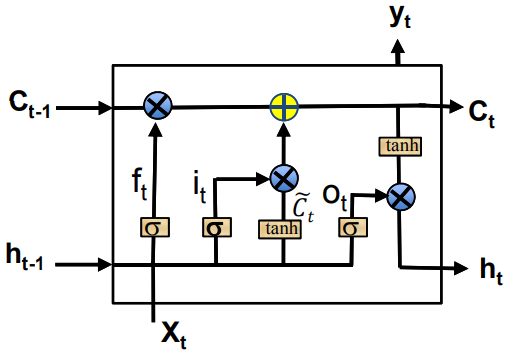

In [37]:
Image(filename='report/lstm_cell.PNG') 

&emsp;
The forward propagation equations for a LSTM module are
$$
\begin{split}
f_t&=\sigma(W^{hf}h_{t-1}+W^{xf}X_t+W^f_0) \\
i_t&=\sigma(W^{hi}h_{t-1}+W^{xi}X_t+W^i_0) \\
o_t&=\sigma(W^{ho}H_{t-1}+W^{xo}X_t+W^o_0) \\
\tilde{C_t}&=tanh(W^{Ch}h_{t-1}+W^{xc}X_t+W^c_0) \\
C_t&=f_t\otimes C_{t-1} \oplus i_t \otimes \tilde{C_t} \\
h_t&=o_t\otimes tanh(C_t) \\
y_t&= softmax(W^yh_t+W^y_0) \\
\end{split}
$$
where $f_t$ is the forget gate which determines if past informations ought to be forgotten. $i_t$ is the memory gate which controls what informations should stored for future states. $o_t$ which decides what information to output. Other intermediate infomation what is generated include the current memory $C_t$, hidden state $h_t$, and output $y_t$.

In [38]:
with tf.name_scope('rnn') as scope:
    multi_lstm_cells = [tf.nn.rnn_cell.LSTMCell(NUM_RNN_UNITS, 
                                          activation=LSTM_ACT_FUN) for _ in range(NUM_RNN_LAYERS)]
    multi_lstm_cells = tf.contrib.rnn.MultiRNNCell(multi_lstm_cells)
    multi_lstm_cells = tf.contrib.rnn.OutputProjectionWrapper(multi_lstm_cells, 
                                                              output_size=np.prod(GT_SHAPE))
    h, _ = tf.nn.dynamic_rnn(multi_lstm_cells, fc_l1, dtype=tf.float32)
    predict_op = tf.reshape(h, shape=(-1,SEQ_LEN, *GT_SHAPE), name='Y_hat')

### 2.4. Define Loss Function
Mean square error loss is used as this is a regression problem not classification.

In [39]:
with tf.name_scope('loss') as scope:
    loss = tf.losses.mean_squared_error(predictions=predict_op, labels=Y)

### 2.5. Optimizer
&emsp;
The backpropagation algorithm for LSTMs are as follows:
$$
\begin{split}
\nabla Y_t&=\frac{\partial\sum\limits_{t=1}^T L(Y_t, \hat{Y}_t)}{\partial\hat{Y}_t} \\
\nabla H_t&=\frac{\partial\sum\limits_{t=1}^T L(Y_t, \hat{Y}_t)}{\partial\hat{H}_t}
\end{split}
$$

$$
\begin{split}
&Given\ \nabla Y_t, \nabla W^y=\frac{\partial\hat{Y}_t}{\partial W^y}\nabla Y_t, 
                    \nabla W_0^y=\frac{\partial\hat{Y}_t}{\partial W_0^y}\nabla Y_t \\
&Given\ \nabla H_t, \nabla o_t=\frac{\partial H_t}{\partial o_t}\nabla H_t, 
                    \nabla C_t=\frac{\partial H_t}{\partial C_t}\nabla H_t \\
&Given\ \nabla o_t, \nabla W^{ho}=\frac{\partial o_t}{\partial W^{ho}}\nabla o_t,
                    \nabla W^{xo}=\frac{\partial o_t}{\partial W^{xo}}\nabla o_t,
                    \nabla W^o_0=\frac{\partial o_t}{\partial W^o_0}\nabla o_t \\
&Given\ \nabla C_t, \nabla f_t=\frac{\partial C_t}{\partial f_t}\nabla C_t,
                    \nabla i_t=\frac{\partial C_t}{\partial i_t}\nabla C_t,
                    \nabla\tilde{C_t}=\frac{\partial C_t}{\partial\tilde{C_t}}\nabla C_t \\
&Given\ \nabla f_t, \nabla W^{hf}=\frac{\partial f_t}{\partial W^{hf}}\nabla f_t,
                    \nabla W^{xf}=\frac{\partial f_t}{\partial W^{xf}}\nabla f_t,
                    \nabla W_0^f=\frac{\partial f_t}{\partial W_0^f}\nabla f_t \\
&Given\ \nabla i_t, \nabla W^{hi}=\frac{\partial i_t}{\partial W^{hi}}\nabla i_t,
                    \nabla W^{xi}=\frac{\partial i_t}{\partial W^{xi}}\nabla i_t,
                    \nabla W_0^i=\frac{\partial i_t}{\partial W_0^i}\nabla i_t \\
&Given\ \nabla\tilde{C_t}, \nabla W^{Ch}=\frac{\partial\tilde{C_t}}{\partial W^{Ch}}\nabla\tilde{C_t},
		                   \nabla W^{Cx}=\frac{\partial\tilde{C_t}}{\partial W^{Cx}}\nabla\tilde{C_t},
		                   \nabla W_0^C=\frac{\partial\tilde{C_t}}{\partial W_0^iC}\nabla\tilde{C_t} \\
\end{split}
$$

Weights are finally updated through gradient descent
$$
W(k)=W(k-1)-\eta\nabla W
$$

In [40]:
with tf.name_scope('train') as scope:
    optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
    train_op = optimizer.minimize(loss)

# 3. Results
&emsp;
Durring tuning of this model, it was discovered that a network that balances the size of the convolutional layer, fully connected, and reccurent layers yields the best results. Initially a CNN with large and a lot of filters and fully connected layers was passed onto to a smaller single layer RNN. Training this network was incredibly slow as fully connected layers store a lot of weights and biases. In the end this network which heavily weighted CNN over RNN produced a rather poor result of 9.3 average pixel error. Afterwards, the CNN filters and fully connected layers was significantly reduced in size. In addition, not only was the number of RNN units increased but more RNN layers were added creating a deep recurrent neural network or DRNN. This architecture was able to get a top result of **3.588 average pixel error**.
#### Misc Useful Features

In [41]:
# How often should we record/print
TB_PERIOD = 10
TRAIN_PERIOD = 10
TEST_PERIOD = 100
SAVE_PERIOD = 500


# For recording test loss/accuracy
test_batch_size = 100
num_test_batches = int(NUM_TESTING_SAMPLE/test_batch_size)
with tf.name_scope('pixel_error') as scope:
    pixel_error_op = tf.subtract(predict_op, Y)
    pixel_error_op = tf.square(pixel_error_op)
    pixel_error_op = tf.reduce_sum(pixel_error_op,axis=3)
    pixel_error_op = tf.sqrt(pixel_error_op, name='pixel_error')
    avg_pixel_error_op = tf.reduce_mean(pixel_error_op, name='avg_pixel_error')

def get_testing_loss_and_error(sess):
    test_loss = 0.
    avg_pixel_error = 0.
    test_data.reset()
    for test_batch in range(num_test_batches):
        X_batch_test, Y_batch_test = test_data.next_batch(test_batch_size)
        test_loss_batch, avg_pixel_error_batch = sess.run([loss, avg_pixel_error_op],
                                                          feed_dict={X: X_batch_test, Y: Y_batch_test})
        test_loss += test_loss_batch
        avg_pixel_error += avg_pixel_error_batch
    test_loss /= num_test_batches
    avg_pixel_error /= num_test_batches
    return test_loss, avg_pixel_error


# For saving a model
tf.get_collection('validation_nodes')
tf.add_to_collection('validation_nodes', X)
tf.add_to_collection('validation_nodes', Y)
tf.add_to_collection('validation_nodes', predict_op)
saver = tf.train.Saver()


# Tensorboard
time_now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
tensorboard_logdir = 'tf_log/run-{}'.format(time_now)
print('tensorboard log_dir: {}'.format(tensorboard_logdir))
writer = tf.summary.FileWriter(tensorboard_logdir)
writer.add_graph(tf.get_default_graph())

tensorboard log_dir: tf_log/run-20180420230215


#### Train Model

In [42]:
# Record training and testing loss and accuracy
train_loss_hist = []
test_loss_hist = []
avg_pixel_error_hist = []

start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in tqdm_notebook(range(1,NUM_STEPS+1), desc='Training'):
        # Load training data
        X_batch_train, Y_batch_train = train_data.random_batch(BATCH_SIZE)
        
        # Record training loss/accuracy
        if step%TRAIN_PERIOD == 0:
            train_loss, train_acc = sess.run([loss, avg_pixel_error_op], 
                                             feed_dict={X:X_batch_train,Y:Y_batch_train})
            train_loss_hist.append(train_loss)
            print('{}+++{}'.format(train_loss, train_acc),end='\r')

        # Record testing loss/accuracy
        if step%TEST_PERIOD == 0 or step == 1:
            test_loss, avg_pixel_error = get_testing_loss_and_error(sess)
            test_loss_hist.append(test_loss)
            avg_pixel_error_hist.append(avg_pixel_error)
            print('Test Step: {:<10} | Loss: {:<25} | Average Pixel Error {:<20}'\
                  .format(step, test_loss, avg_pixel_error))

        # Save model
        if step%SAVE_PERIOD == 0:
            print('saving model with avg pixel error: {:.3f}'.format(avg_pixel_error_hist[-1]))
            saver_filename = 'models/a{:.3f}_e{}'.format(avg_pixel_error_hist[-1], step)
            saver.save(sess, saver_filename)
        
        # Train model
        sess.run(train_op, feed_dict={X:X_batch_train, Y:Y_batch_train,training:True})
        
    # Get 100 pixel errors for plotting
    X_batch_test, Y_batch_test = test_data.random_batch(100)
    pixel_errors = sess.run(pixel_error_op, feed_dict={X:X_batch_test,Y:Y_batch_test})

time_elapse = time.time()-start_time
print('{:.3f} sec, {} iterations, {:.3f} iterations/sec'.format(time_elapse, NUM_STEPS, NUM_STEPS/time_elapse))

A Jupyter Widget


Test Step: 1          | Loss: 1059.9524637858074        | Average Pixel Error 44.9645562171936    
Test Step: 100        | Loss: 255.3481419881185         | Average Pixel Error 18.67020257314046   
Test Step: 200        | Loss: 133.25838470458984        | Average Pixel Error 13.333184480667114  
Test Step: 300        | Loss: 91.8137788772583          | Average Pixel Error 10.652205268541971  
Test Step: 400        | Loss: 82.88596566518147         | Average Pixel Error 10.171035766601562  
Test Step: 500        | Loss: 67.95482842127483         | Average Pixel Error 9.271525422732035   
Test Step: 600        | Loss: 60.76139307022095         | Average Pixel Error 8.988447546958923   
Test Step: 700        | Loss: 64.49237998326619         | Average Pixel Error 9.206212162971497   
Test Step: 800        | Loss: 60.04817612965902         | Average Pixel Error 9.069587786992392   
Test Step: 900        | Loss: 50.33781210581461         | Average Pixel Error 8.391647855440775   
Test Step

### 3.1. Plot Loss

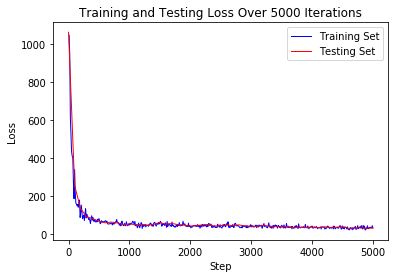

In [65]:
plt.figure()
plt.plot(np.linspace(TRAIN_PERIOD, NUM_STEPS, int(NUM_STEPS/TRAIN_PERIOD)),
         train_loss_hist, 'b-', linewidth = 1.0)
plt.plot(np.linspace(0, NUM_STEPS, int((NUM_STEPS+TEST_PERIOD)/TEST_PERIOD)),
         test_loss_hist,'r-', linewidth = 1.0)
plt.title('Training and Testing Loss Over {} Iterations'.format(NUM_STEPS))
plt.legend(['Training Set', 'Testing Set'])
plt.ylabel('Loss')
plt.xlabel('Step')
plt.show()

### 3.2. Plot Average Pixel Error

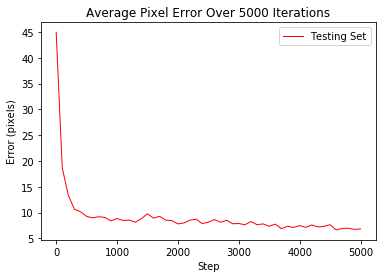

In [62]:
plt.figure()
plt.plot(np.linspace(0, NUM_STEPS, int((NUM_STEPS+TEST_PERIOD)/TEST_PERIOD)),
         avg_pixel_error_hist,'r-', linewidth = 1.0)
plt.title('Average Pixel Error Over {} Iterations'.format(NUM_STEPS))
plt.legend(['Testing Set'])
plt.ylabel('Error (pixels)')
plt.xlabel('Step')
plt.show()

### 3.3. Plot Pixel Accuracy Per Joint

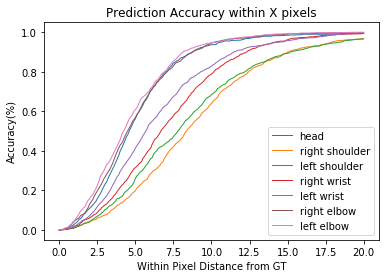

In [63]:
max_pixel_range = 20
plot_steps = 200
pixel_range = np.linspace(0, max_pixel_range, plot_steps+1)
accuracy_within_range = np.array([np.mean(np.less(pixel_errors,pix_dist),axis=(0,1)) 
                                  for pix_dist in pixel_range])

plt.figure()
plt.plot(pixel_range, accuracy_within_range, linewidth = 1.0)
plt.xlabel('Within Pixel Distance from GT')
plt.ylabel('Accuracy(%)')
plt.title('Prediction Accuracy within X pixels')
plt.legend(['head', 'right shoulder', 'left shoulder', 'right wrist', 'left wrist', 'right elbow', 'left elbow'])
plt.show()